In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix, classification_report, confusion_matrix, fbeta_score, precision_score, roc_curve, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

In [4]:
import imblearn

# Data cleaning & prepocessing

### Import data

In [5]:
df = pd.read_csv("fake_job_postings.csv", skipinitialspace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6327 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
df=df.replace(np.nan,"")

In [8]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Remove unneccesary columns

In [9]:
columns=['job_id', 'telecommuting', 'has_questions', 'salary_range']
for col in columns:
    del df[col]

### Format company logo column

In [10]:
df['has_company_logo'] = df['has_company_logo'].replace({1:'company logo: yes', 0: 'company logo: no'})

### Combine text in a single column

In [11]:
text_data=df.select_dtypes(include="object")
text_data.drop(["location"],axis=1,inplace=True)
text_col=text_data.columns
df[text_col]=df[text_col].replace(np.nan,"")

In [12]:
df['text'] = ""
for col in text_data.columns:
    df["text"]=df["text"]+" "+df[col]

### Drop columns

In [13]:
columns=['title', 'location','department', 'company_profile', 'employment_type','description', 'requirements', 'benefits','industry', 'function', 'has_company_logo', 'required_experience', 'required_education']
for col in columns:
    del df[col]

In [14]:
df.head()

,fraudulent,text
0,0,"Marketing Intern Marketing We're Food52, and ..."
1,0,Customer Service - Cloud Video Production Suc...
2,0,Commissioning Machinery Assistant (CMA) Valo...
3,0,Account Executive - Washington DC Sales Our p...
4,0,Bill Review Manager SpotSource Solutions LLC...


### Data cleaning

In [15]:
stop = set(stopwords.words("english"))
def clean(text):
    
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
    
    stemmer = SnowballStemmer("english")
    text=[stemmer.stem(word) for word in text.split() if word not in stop]

    porter_stemmer = PorterStemmer()             #defining the object for stemming
    text = [porter_stemmer.stem(word) for word in text]
    wordnet_lemmatizer = WordNetLemmatizer()     #lemmatization
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

In [16]:
df["text"] = df["text"].apply(clean)

This step may take awhile to run since there are 18000+ texts to clean

In [17]:
df.head()

,fraudulent,text
0,0,market intern market food creat groundbreak aw...
1,0,custom servic cloud video product success seco...
2,0,commiss machineri assist cma valor servic prov...
3,0,account execut washington dc sale passion impr...
4,0,bill review manag spotsourc solut llc global h...


In [18]:
df['text'][0] #check the cleaned text of the first row

'market intern market food creat groundbreak award win cook site support connect celebr home cook give everyth need one place top editori busi engin team focu use technolog find new better way connect peopl around specif food interest offer superb high curat inform food cook attract talent home cook contributor countri also publish well known profess like mario batali gwyneth paltrow danni meyer partnership whole food market random hou food name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today show locat chelsea new york citi food fast grow jame beard award win onlin food commun crowd sourc curat recip hub current interview full part time unpaid intern work small team editor execut develop new york citi headquart reproduc repackag exist food content number partner site huffington post yahoo buzzf variou content manag systemsresearch blog websit provi food affili programassist day day affili program support screen affili assist affili inquir

### Vectorizer

In [19]:
# Target Selection
x_sample = df['text']
y_sample = df['fraudulent']
#split
X_train, X_test, y_train, y_test = train_test_split(
    x_sample, y_sample,
    test_size=0.3,
    stratify=y_sample,
    random_state=42
)

In [20]:
X_train.to_csv("copyXtrain.csv", index = False) #save a copy of X_train for later use (Vectorizer in the streamlit app)

In [21]:
# Apply vectorizer
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train =  tfidf.transform(X_train)
X_test= tfidf.transform(X_test)

In [22]:
# make a copy of imbalanced X_train, X_test
X_train_imbalanced =  X_train
X_test_imbalanced = X_test
y_train_imbalanced = y_train
y_test_imbalanced = y_test

# Handle imbalanced dataset: Oversampling & Undersampling

In [23]:
from collections import Counter
from imblearn.combine import SMOTETomek #Oversampling
from imblearn.under_sampling import TomekLinks #Undersampling

In [24]:
print(Counter(y_train))

Counter({0: 11910, 1: 606})


In the train set, there are 11910 real and 606 fake job ads --> highly imbalanced

In [25]:
# define resampling
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [26]:
# fit and apply the transform
X_train, y_train = resample.fit_resample(X_train, y_train)

This step may take awhile to run

In [27]:
print(Counter(y_train))

Counter({0: 11910, 1: 11910})


Now, the train set is balanced

# Classification Model

## 1. Logistic Regression

In [28]:
logreg = LogisticRegression(random_state = 42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### Predict on train set

In [29]:
y_train_logreg_pred = logreg.predict(X_train)

<AxesSubplot:>

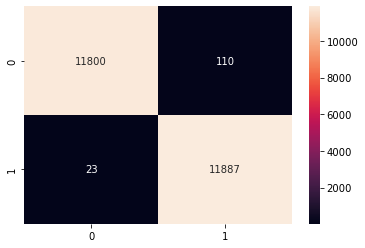

In [30]:
sb.heatmap(confusion_matrix(y_train, y_train_logreg_pred), annot = True, fmt="d")

In [31]:
# Evaluation of model's performance on train set
print("Logistic Regression Accuracy:", accuracy_score(y_train, y_train_logreg_pred))
print("Logistic Regression Recall:", recall_score(y_train, y_train_logreg_pred))
print("Logistic Regression Precision:", precision_score(y_train, y_train_logreg_pred))
print("Logistic Regression F2 score:", fbeta_score(y_train, y_train_logreg_pred, average='binary', beta=2))
print('Logistic Regression ROC AUC Score', roc_auc_score(y_train, y_train_logreg_pred))

Logistic Regression Accuracy: 0.994416456759026
Logistic Regression Recall: 0.9980688497061293
Logistic Regression Precision: 0.9908310410936068
Logistic Regression F2 score: 0.9966128410215134
Logistic Regression ROC AUC Score 0.994416456759026


#### Predict on test set

In [32]:
y_test_logreg_pred = logreg.predict(X_test)

<AxesSubplot:>

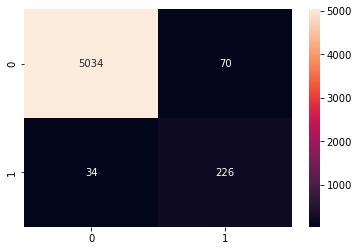

In [33]:
sb.heatmap(confusion_matrix(y_test, y_test_logreg_pred), annot = True, fmt="d")

In [34]:
# Evaluation of model's performance on test set
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_test_logreg_pred))
print("Logistic Regression Recall:", recall_score(y_test, y_test_logreg_pred))
print("Logistic Regression Precision:", precision_score(y_test, y_test_logreg_pred))
print("Logistic Regression F2 score:", fbeta_score(y_test, y_test_logreg_pred, average='binary', beta=2))
print('Logistic Regression ROC AUC Score', roc_auc_score(y_test, y_test_logreg_pred))

Logistic Regression Accuracy: 0.9806114839671887
Logistic Regression Recall: 0.8692307692307693
Logistic Regression Precision: 0.7635135135135135
Logistic Regression F2 score: 0.845808383233533
Logistic Regression ROC AUC Score 0.9277580178442246


In [35]:
print("Logistic Regression F1 score:", fbeta_score(y_test, y_test_logreg_pred, average='binary', beta=1))

Logistic Regression F1 score: 0.8129496402877696


## 2. Random Forest

In [36]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

#### Predict on train test

In [37]:
y_fr_train_pred = forest.predict(X_train)

<AxesSubplot:>

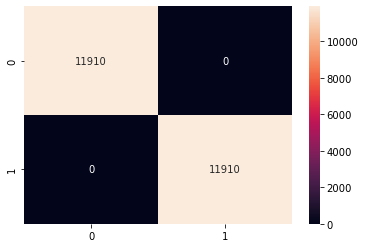

In [38]:
sb.heatmap(confusion_matrix(y_train, y_fr_train_pred), annot = True, fmt="d")

In [39]:
# Evaluation of model's performance on train set
print("Random Forest Accuracy:", accuracy_score(y_train, y_fr_train_pred))
print("Random Forest Recall:", recall_score(y_train, y_fr_train_pred))
print("Random Forest Precision:", precision_score(y_train, y_fr_train_pred))
print("Random Forest F2 score:", fbeta_score(y_train, y_fr_train_pred, average='binary', beta=2))
print('Random Forest ROC AUC Score', roc_auc_score(y_train, y_fr_train_pred))

Random Forest Accuracy: 1.0
Random Forest Recall: 1.0
Random Forest Precision: 1.0
Random Forest F2 score: 1.0
Random Forest ROC AUC Score 1.0


Risk of overfitting

#### Predict on test set

In [40]:
y_fr_test_pred = forest.predict(X_test)

<AxesSubplot:>

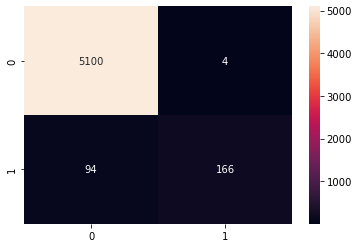

In [41]:
sb.heatmap(confusion_matrix(y_test, y_fr_test_pred), annot = True, fmt="d")

In [42]:
# Evaluation of model's performance on test set
print("Random Forest Accuracy:", accuracy_score(y_test, y_fr_test_pred))
print("Random Forest Recall:", recall_score(y_test, y_fr_test_pred))
print("Random Forest Precision:", precision_score(y_test, y_fr_test_pred))
print("Random Forest F2 score:", fbeta_score(y_test, y_fr_test_pred, average='binary', beta=2))
print('Random Forest ROC AUC Score', roc_auc_score(y_test, y_fr_test_pred))

Random Forest Accuracy: 0.9817300521998509
Random Forest Recall: 0.6384615384615384
Random Forest Precision: 0.9764705882352941
Random Forest F2 score: 0.6859504132231404
Random Forest ROC AUC Score 0.8188389197009887


## 3. Support Vector Machine

#### a. Apply Argument Class Weight on Imbalanced Data

In [43]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_imbalanced, y_train_imbalanced)

SVC(class_weight='balanced')

#### Predict on train set

In [44]:
y_svm_train_imbalanced_pred = svm.predict(X_train_imbalanced)

In [45]:
# Evaluation of model's performance on train set
print("SVM Accuracy:", accuracy_score(y_train_imbalanced, y_svm_train_imbalanced_pred))
print("SVM Recall:", recall_score(y_train_imbalanced, y_svm_train_imbalanced_pred))
print("SVM Precision:", precision_score(y_train_imbalanced, y_svm_train_imbalanced_pred))
print("SVM F2 score:", fbeta_score(y_train_imbalanced, y_svm_train_imbalanced_pred, average='binary', beta=2))
print('SVM ROC AUC Score', roc_auc_score(y_train_imbalanced, y_svm_train_imbalanced_pred))

SVM Accuracy: 0.9993608181527645
SVM Recall: 1.0
SVM Precision: 0.9869706840390879
SVM F2 score: 0.9973666886109283
SVM ROC AUC Score 0.999664147774979


#### Predict on test set

In [46]:
y_svm_test_imbalanced_pred = svm.predict(X_test)

In [47]:
# Evaluation of model's performance on test set
print("SVM Accuracy:", accuracy_score(y_test, y_svm_test_imbalanced_pred))
print("SVM Recall:", recall_score(y_test, y_svm_test_imbalanced_pred))
print("SVM Precision:", precision_score(y_test, y_svm_test_imbalanced_pred))
print("SVM F2 score:", fbeta_score(y_test, y_svm_test_imbalanced_pred, average='binary', beta=2))
print('SVM ROC AUC Score', roc_auc_score(y_test, y_svm_test_imbalanced_pred))

SVM Accuracy: 0.9875093214019388
SVM Recall: 0.7538461538461538
SVM Precision: 0.9849246231155779
SVM F2 score: 0.7909604519774012
SVM ROC AUC Score 0.8766291897757416


#### b. Balanced data by SMOTE

In [48]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

This model takes the longest to run.

#### Predict on train set

In [49]:
y_svm_train_pred = svm.predict(X_train)

<AxesSubplot:>

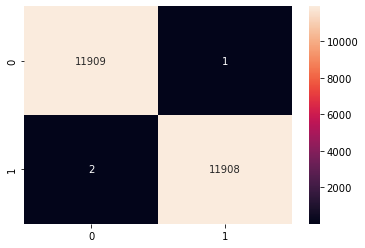

In [50]:
sb.heatmap(confusion_matrix(y_train, y_svm_train_pred), annot = True, fmt="d")

In [51]:
# Evaluation of model's performance on train set
print("SVM Accuracy:", accuracy_score(y_train, y_svm_train_pred))
print("SVM Recall:", recall_score(y_train, y_svm_train_pred))
print("SVM Precision:", precision_score(y_train, y_svm_train_pred))
print("SVM F2 score:", fbeta_score(y_train, y_svm_train_pred, average='binary', beta=2))
print('SVM ROC AUC Score', roc_auc_score(y_train, y_svm_train_pred))

SVM Accuracy: 0.9998740554156171
SVM Recall: 0.9998320738874895
SVM Precision: 0.9999160298933579
SVM F2 score: 0.9998488639607719
SVM ROC AUC Score 0.9998740554156171


#### Predict on test set

In [52]:
y_svm_test_pred = svm.predict(X_test)

<AxesSubplot:>

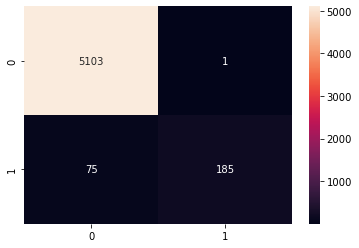

In [53]:
sb.heatmap(confusion_matrix(y_test, y_svm_test_pred), annot = True, fmt="d")

In [54]:
# Evaluation of model's performance on test set
print("SVM Accuracy:", accuracy_score(y_test, y_svm_test_pred))
print("SVM Recall:", recall_score(y_test, y_svm_test_pred))
print("SVM Precision:", precision_score(y_test, y_svm_test_pred))
print("SVM F2 score:", fbeta_score(y_test, y_svm_test_pred, average='binary', beta=2))
print('SVM ROC AUC Score', roc_auc_score(y_test, y_svm_test_pred))

SVM Accuracy: 0.9858314690529456
SVM Recall: 0.7115384615384616
SVM Precision: 0.9946236559139785
SVM F2 score: 0.7544861337683523
SVM ROC AUC Score 0.8556712683867856


## 4. XGBoost Classifier

In [55]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Predict on train set

In [56]:
y_xgb_train_pred = xgb.predict(X_train)

<AxesSubplot:>

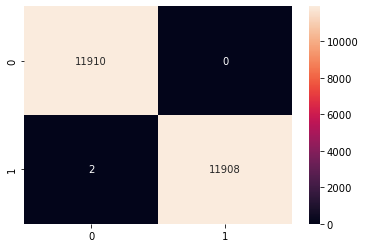

In [57]:
sb.heatmap(confusion_matrix(y_train, y_xgb_train_pred), annot = True, fmt="d")

In [58]:
# Evaluation of model's performance on train set
print("XGB Accuracy:", accuracy_score(y_train, y_xgb_train_pred))
print("XGB Recall:", recall_score(y_train, y_xgb_train_pred))
print("XGB Precision:", precision_score(y_train, y_xgb_train_pred))
print("XGB F2 score:", fbeta_score(y_train, y_xgb_train_pred, average='binary', beta=2))
print('XGB ROC AUC Score', roc_auc_score(y_train, y_xgb_train_pred))

XGB Accuracy: 0.9999160369437448
XGB Recall: 0.9998320738874895
XGB Precision: 1.0
XGB F2 score: 0.9998656545979714
XGB ROC AUC Score 0.9999160369437448


#### Predict on test set

In [59]:
y_xgb_test_pred = xgb.predict(X_test)

<AxesSubplot:>

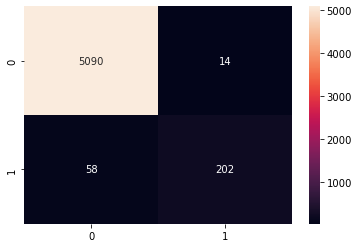

In [60]:
sb.heatmap(confusion_matrix(y_test, y_xgb_test_pred), annot = True, fmt="d")

In [61]:
# Evaluation of model's performance on test set
print("XGB Accuracy:", accuracy_score(y_test, y_xgb_test_pred))
print("XGB Recall:", recall_score(y_test, y_xgb_test_pred))
print("XGB Precision:", precision_score(y_test, y_xgb_test_pred))
print("XGB F2 score:", fbeta_score(y_test, y_xgb_test_pred, average='binary', beta=2))
print('XGB ROC AUC Score', roc_auc_score(y_test, y_xgb_test_pred))

XGB Accuracy: 0.9865771812080537
XGB Recall: 0.7769230769230769
XGB Precision: 0.9351851851851852
XGB F2 score: 0.804140127388535
XGB ROC AUC Score 0.8870900651073065


In [62]:
print("XGB F1 score:", fbeta_score(y_test, y_xgb_test_pred, average='binary', beta=1))

XGB F1 score: 0.8487394957983193


## 5. KNeighbors Classifier

In [63]:
knc = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knc.fit(X_train, y_train)

KNeighborsClassifier()

#### Predict on train set

In [64]:
y_knc_train_pred = knc.predict(X_train)

<AxesSubplot:>

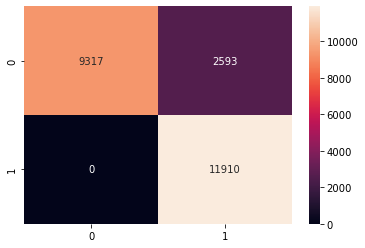

In [65]:
sb.heatmap(confusion_matrix(y_train, y_knc_train_pred), annot = True, fmt="d")

In [66]:
# Evaluation of model's performance on train set
print("KNC Accuracy:", accuracy_score(y_train, y_knc_train_pred))
print("KNC Recall:", recall_score(y_train, y_knc_train_pred))
print("KNC Precision:", precision_score(y_train, y_knc_train_pred))
print("KNC F2 score:", fbeta_score(y_train, y_knc_train_pred, average='binary', beta=2))
print('KNC ROC AUC Score', roc_auc_score(y_train, y_knc_train_pred))

KNC Accuracy: 0.8911418975650713
KNC Recall: 1.0
KNC Precision: 0.8212094049506998
KNC F2 score: 0.9582736591410136
KNC ROC AUC Score 0.8911418975650713


#### Predict on test set

In [67]:
y_knc_test_pred = knc.predict(X_test)

<AxesSubplot:>

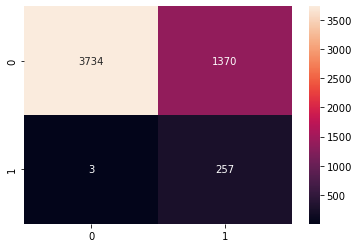

In [68]:
sb.heatmap(confusion_matrix(y_test, y_knc_test_pred), annot = True, fmt="d")

In [69]:
# Evaluation of model's performance on test set
print("KNC Accuracy:", accuracy_score(y_test, y_knc_test_pred))
print("KNC Recall:", recall_score(y_test, y_knc_test_pred))
print("KNC Precision:", precision_score(y_test, y_knc_test_pred))
print("KNC F2 score:", fbeta_score(y_test, y_knc_test_pred, average='binary', beta=2))
print('KNC ROC AUC Score', roc_auc_score(y_test, y_knc_test_pred))

KNC Accuracy: 0.744034302759135
KNC Recall: 0.9884615384615385
KNC Precision: 0.15795943454210204
KNC F2 score: 0.48181477315335586
KNC ROC AUC Score 0.860022305280926


## 6. Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier
dectree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dectree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

#### Predict on Train set

In [71]:
y_tree_train_pred = dectree.predict(X_train)

<AxesSubplot:>

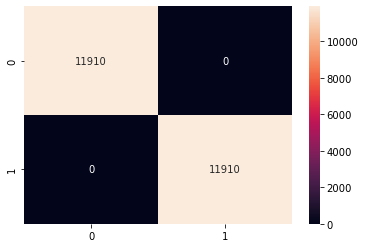

In [72]:
sb.heatmap(confusion_matrix(y_train, y_tree_train_pred), annot = True, fmt="d")

In [73]:
# Evaluation of model's performance on train set
print("Decision Tree Accuracy:", accuracy_score(y_train, y_tree_train_pred))
print("Decision Tree Recall:", recall_score(y_train, y_tree_train_pred))
print("Decision Tree Precision:", precision_score(y_train, y_tree_train_pred))
print("Decision Tree F2 score:", fbeta_score(y_train, y_tree_train_pred, average='binary', beta=2))
print('Decision Tree ROC AUC Score', roc_auc_score(y_train, y_tree_train_pred))

Decision Tree Accuracy: 1.0
Decision Tree Recall: 1.0
Decision Tree Precision: 1.0
Decision Tree F2 score: 1.0
Decision Tree ROC AUC Score 1.0


Risk of overfitting

#### Predict on test set

In [74]:
y_tree_test_pred = dectree.predict(X_test)

<AxesSubplot:>

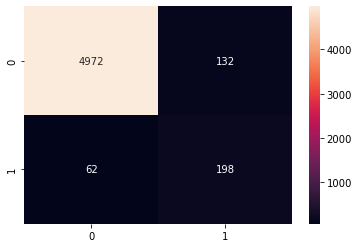

In [75]:
sb.heatmap(confusion_matrix(y_test, y_tree_test_pred), annot = True, fmt="d")

In [76]:
# Evaluation of model's performance on test set
print("Decision Tree Accuracy:", accuracy_score(y_test, y_tree_test_pred))
print("Decision Tree Recall:", recall_score(y_test, y_tree_test_pred))
print("Decision Tree Precision:", precision_score(y_test, y_tree_test_pred))
print("Decision Tree F2 score:", fbeta_score(y_test, y_tree_test_pred, average='binary', beta=2))
print('Decision Tree ROC AUC Score', roc_auc_score(y_test, y_tree_test_pred))

Decision Tree Accuracy: 0.9638329604772558
Decision Tree Recall: 0.7615384615384615
Decision Tree Precision: 0.6
Decision Tree F2 score: 0.7226277372262774
Decision Tree ROC AUC Score 0.8678381962864722


## Evaluation 6 Models

In [77]:
roc_score = {}
f2_score = {}
rc_score = {}
pr_score = {}

In [78]:
roc_score['Logistic Regression']= roc_auc_score(y_test, y_test_logreg_pred)
roc_score['Random Forest']= roc_auc_score(y_test, y_fr_test_pred)
roc_score['SVM']= roc_auc_score(y_test, y_svm_test_pred)
roc_score['XGBoost']= roc_auc_score(y_test, y_xgb_test_pred)
roc_score['K-Neighbour Classifier']= roc_auc_score(y_test, y_knc_test_pred)
roc_score['Decision Tree']= roc_auc_score(y_test, y_tree_test_pred)

In [79]:
f2_score['Logistic Regression']= fbeta_score(y_test, y_test_logreg_pred, average='binary', beta=2)
f2_score['Random Forest']= fbeta_score(y_test, y_fr_test_pred, average='binary', beta=2)
f2_score['SVM']= fbeta_score(y_test, y_svm_test_pred, average='binary', beta=2)
f2_score['XGBoost']= fbeta_score(y_test, y_xgb_test_pred, average='binary', beta=2)
f2_score['K-Neighbour Classifier']= fbeta_score(y_test, y_knc_test_pred, average='binary', beta=2)
f2_score['Decision Tree']= fbeta_score(y_test, y_tree_test_pred, average='binary', beta=2)

In [80]:
rc_score['Logistic Regression']= recall_score(y_test, y_test_logreg_pred)
rc_score['Random Forest']= recall_score(y_test, y_fr_test_pred)
rc_score['SVM']= recall_score(y_test, y_svm_test_pred)
rc_score['XGBoost']= recall_score(y_test, y_xgb_test_pred)
rc_score['K-Neighbour Classifier']= recall_score(y_test, y_knc_test_pred)
rc_score['Decision Tree']= recall_score(y_test, y_tree_test_pred)

In [81]:
pr_score['Logistic Regression']= precision_score(y_test, y_test_logreg_pred)
pr_score['Random Forest']= precision_score(y_test, y_fr_test_pred)
pr_score['SVM']= precision_score(y_test, y_svm_test_pred)
pr_score['XGBoost']= precision_score(y_test, y_xgb_test_pred)
pr_score['K-Neighbour Classifier']= precision_score(y_test, y_knc_test_pred)
pr_score['Decision Tree']= precision_score(y_test, y_tree_test_pred)

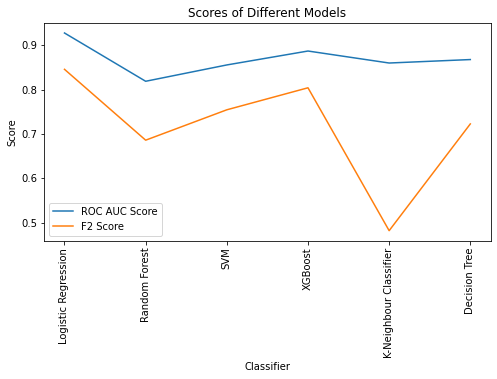

In [82]:
#Plot ROC AUC Score and F2 Score
plt.figure(figsize=(8, 4))
plt.plot(list(roc_score.values()));
plt.plot(list(f2_score.values()));
plt.xticks(ticks=range(0, len(roc_score)), labels=roc_score.keys(), rotation=90);
plt.title('Scores of Different Models');
plt.xlabel('Classifier');
plt.ylabel('Score');
plt.legend(['ROC AUC Score', 'F2 Score'], fontsize='medium');

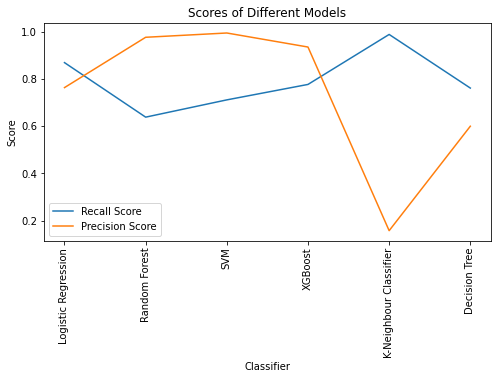

In [83]:
#Plot Recall and Precision Score
plt.figure(figsize=(8, 4))
plt.plot(list(rc_score.values()));
plt.plot(list(pr_score.values()));
plt.xticks(ticks=range(0, len(rc_score)), labels=roc_score.keys(), rotation=90);
plt.title('Scores of Different Models');
plt.xlabel('Classifier');
plt.ylabel('Score');
plt.legend(['Recall Score', 'Precision Score'], fontsize='medium');


# Conclusion

Since want to use minimize False Negative (incorrectly predict fraudulent jobs as non-fraudulent), we pay more attention to Recall and F2 score. When there are more than 1 model with approximately the same recall and F2 score, we take other evaluation metrics (accuracy, prediction, F1 score, AUC ROC score) in to consideration.

We can see that **Logistic Regression model** has the best overall performance on the test set among all the models.

'''
base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1,
'''

# Save the model

In [84]:
from joblib import dump, load

In [85]:
dump(logreg, 'logregmodel.joblib')

['logregmodel.joblib']

# Load the saved model

In [86]:
model = load('logregmodel.joblib') 

# Try to predict an input

## Predict a fake job posting from the dataset

In [87]:
title = input()

IC&E Technician


In [88]:
department = input()

Oil & Energy


In [89]:
company_profile = input()

Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â  Â Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically granted the following perks: Expert negotiations on your behalf, maximizing your compensation package and implimenting ongoing increasesÂ Significant signing bonus by Refined Resources (in addition to any potential signing bonuses our client companies offer)1 Year access to AnyPerk: significant corporate discounts on cell phones, event tickets, house cleaning and everything inbetween. Â You'll save thousands on daily expendituresÂ Professional Relocation Services for out of town candidates* All candidates are encouraged to participate in our Referral Bonus Program ranging anywhere from $500 - $1,000 for all successfully hired candidates... referred directly to the Refined Resources teamPlease submit referrals via online Referral FormThank you and we look f

In [90]:
description = input()

IC&amp;E Technician | Bakersfield, CA Mt. PosoPrincipal Duties and Responsibilities:Â Calibrates, tests, maintains, troubleshoots, and installs all power plant instrumentation, control systems and electrical equipment.Performs maintenance on motor control centers, motor operated valves, generators, excitation equipment and motors.Performs preventive, predictive and corrective maintenance on equipment, coordinating work with various team members.Designs and installs new equipment and/or system modifications.Troubleshoots and performs maintenance on DC backup power equipment, process controls, programmable logic controls (PLC), and emission monitoring equipment.Uses maintenance reporting system to record time and material use, problem identified and corrected, and further action required; provides complete history of maintenance on equipment.Schedule, coordinate, work with and monitor contractors on specific tasks, as required.Follows safe working practices at all times.Identifies safety

In [91]:
requirements = input()

IC&amp;E Technician | Bakersfield, CA Mt. PosoPrincipal Duties and Responsibilities:Â Calibrates, tests, maintains, troubleshoots, and installs all power plant instrumentation, control systems and electrical equipment.Performs maintenance on motor control centers, motor operated valves, generators, excitation equipment and motors.Performs preventive, predictive and corrective maintenance on equipment, coordinating work with various team members.Designs and installs new equipment and/or system modifications.Troubleshoots and performs maintenance on DC backup power equipment, process controls, programmable logic controls (PLC), and emission monitoring equipment.Uses maintenance reporting system to record time and material use, problem identified and corrected, and further action required; provides complete history of maintenance on equipment.Schedule, coordinate, work with and monitor contractors on specific tasks, as required.Follows safe working practices at all times.Identifies safety

In [92]:
benefits = input()

BENEFITSWhat is offered:Competitive compensation package100% matched retirement fundAnnual vacations paid for by companySignificant bonus structureOpportunity for advancementÂ Full benefits packageAnnual performance reviews and base salary increasesAnnual cost of living increasesÂ Sound, clean, safe and enjoyable working environment &amp; Company CultureWorld renound management and executive team who promote from within, leverage careers and invest in employees for the long-term success of their careers and overall company/employee goalsQualified candidates contact:Â Darren Lawson | VP of Recruiting |Â #EMAIL_395225df8eed70288fc67310349d63d49d5f2ca6bc14dbb5dcbf9296069ad88c#Â | #PHONE_70128aad0c118273b0c2198a08d528591b932924e165b6a8d1272a6f9e2763d1#Â Â Â


In [93]:
employment_type = input()

Full-time


In [94]:
required_experience = input()

Mid-Senior level


In [95]:
required_education = input()

High School or equivalent


In [96]:
industry = input()

Oil & Energy


In [97]:
function = input()

Other


In [98]:
trial = pd.DataFrame({'title':title,'department':department,'company_profile':company_profile,'description':description,'requirements':requirements,'benefits':benefits,'employment_type':employment_type, "required_experience":required_experience, "required_education":required_education, "industry":industry, "function":function}, index=[0])

In [99]:
trial.head()

,title,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
0,IC&E Technician,Oil & Energy,Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","IC&amp;E Technician | Bakersfield, CA Mt. Poso...",BENEFITSWhat is offered:Competitive compensati...,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other


#### Combine text columns

In [100]:
text_data=trial.select_dtypes(include="object")
text_col=text_data.columns
trial[text_col]=trial[text_col].replace(np.nan,"")

In [101]:
trial['text'] = ""
for col in text_data.columns:
    trial["text"] = trial["text"] + " " + trial[col]

In [102]:
predictor = trial[['text']]

In [103]:
predictor.head()

,text
0,IC&E Technician Oil & Energy Â Â Â Â Â Â...


#### Clean the text

In [104]:
predictor["text"]=predictor["text"].apply(clean)

C:\Users\Pham Thuy Linh\AppData\Local\Temp\ipykernel_5968\311436810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor["text"]=predictor["text"].apply(clean)


In [105]:
predictor['text'][0]

'ic technician oil energi staf amp recruit done right oil amp energi industri repr candid automat grant follow perk expert negoti behalf maxim compen packag impliment ongo increasesâ signif sign bonu refin resourc addit potenti sign bonu client compani offer year access anyperk signif corpor discount cell phone event ticket hou clean everyth inbetween save thousand daili expendituresâ profess reloc servic town candid candid encourag particip referr bonu program rang anywh success hire candid refer direct refin resourc teamplea submit referr via onlin referr formthank look forward work soon click enlarg imag ic amp technician bakersfield ca mt posoprincip duti respon calibr test maintain troubleshoot instal power plant instrument control system electr equip perform mainten motor control center motor oper valv generat excit equip motor perform prevent predict correct mainten equip coordin work variou team member design instal new equip system modif troubleshoot perform mainten dc backup 

#### Vectorizer

In [106]:
X_trial = tfidf.transform(predictor['text'])

In [107]:
X_trial

<1x68435 sparse matrix of type '<class 'numpy.float64'>'
	with 257 stored elements in Compressed Sparse Row format>

#### Predict (result: fake)

In [108]:
y_trial = model.predict(X_trial)

In [109]:
y_trial

array([1], dtype=int64)

In [110]:
print(y_trial)

[1]


In [111]:
type(y_trial)

numpy.ndarray

In [112]:
y_trial[0]

1

**--> correctly predict fraudulent job ad**

## Predict (a real job from Shopee Career - not in the dataset)

In [113]:
title = input()

Data Analytics Intern


In [114]:
department = input()

Cross Border eCommerce


In [115]:
company_profile = input()

The Cross Border team at Shopee empowers sellers from all over the world to sell into the Southeast Asia and Taiwan region. The team helps sellers to market their products across the 7 markets and provide enabling services such as cross border logistics, operations, payments, product related services, overseas warehouse fulfillment and business intelligence. Browse our Cross Border eCommerce team openings to see how you can make an impact with us.


In [116]:
description = input()

Analyse cross border performance and develop insights on the driving factors behind the figures using SQL and Python Monitor operational key performance indexes and conduct root cause analysis on key performance index fluctuation for feedback to local teams Understand the current systems’ capabilities and limitations and provide continuous improvement for systems and processes Provide feedback to and collaborate with other departments to improve overall operations efficiency


In [117]:
requirements = input()

Currently pursuing a Bachelor's Degree with majors in relevant field Strong analytical skill and sensitivity to data Strong oral and written communication skill Creative and innovative approach to solving problems Positive, team-player, and energetic attitude Strong knowledge in Microsoft Excel Knowledge in SQL and/or Python is required Full-time interns preferred (3-6 months) Part-time interns who can commit at least 3 working days a week are also welcome to apply


In [118]:
benefits = input()

In [119]:
employment_type = input()

Full-time


In [120]:
required_experience = input()

Internship


In [121]:
required_education = input()

Bachelor's Degree


In [122]:
industry = input()

Technology


In [123]:
function = input()

In [124]:
trial = pd.DataFrame({'title':title,'department':department,'company_profile':company_profile,'description':description,'requirements':requirements,'benefits':benefits,'employment_type':employment_type, "required_experience":required_experience, "required_education":required_education, "industry":industry, "function":function}, index=[0])

In [125]:
trial.head()

,title,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
0,Data Analytics Intern,Cross Border eCommerce,The Cross Border team at Shopee empowers selle...,Analyse cross border performance and develop i...,Currently pursuing a Bachelor's Degree with ma...,,Full-time,Internship,Bachelor's Degree,Technology,


#### Combine text columns

In [126]:
text_data=trial.select_dtypes(include="object")
text_col=text_data.columns
trial[text_col]=trial[text_col].replace(np.nan,"")

In [127]:
trial['text'] = ""
for col in text_data.columns:
    trial["text"] = trial["text"] + " " + trial[col]

In [128]:
predictor = trial[['text']]

In [129]:
predictor.head()

,text
0,Data Analytics Intern Cross Border eCommerce ...


#### Clean the text

In [130]:
#apply clean text function
predictor["text"]=predictor["text"].apply(clean)

C:\Users\Pham Thuy Linh\AppData\Local\Temp\ipykernel_5968\813550249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor["text"]=predictor["text"].apply(clean)


In [131]:
predictor['text'][0]

'data analyt intern cross border ecommerc cross border team shope empow seller world sell southeast asia taiwan region team help seller market product across market provid enabl servic cross border logist oper payment product relat servic oversea wareh fulfil busi intellig brow cross border ecommerc team open see make impact us anali cross border perform develop insight drive factor behind figur use sql python monitor oper key perform index conduct root cau analysi key perform index fluctuat feedback local team understand current system capabl limit provid continu improv system process provid feedback collabor depart improv over oper effici current pursu bachelor degr major relev field strong analyt skill sensit data strong oral written commun skill creativ innov approach solv problem posit team player energet attitud strong knowledg microsoft excel knowledg sql python requir full time intern prefer month part time intern commit least work day week also welcom appli full time internshi

#### Vectorizer

In [132]:
X_trial = tfidf.transform(predictor['text'])

#### Predict (correct result: 0 = real)

In [133]:
y_trial = model.predict(X_trial)

In [134]:
print(y_trial)

[0]


--> **correctly predict a real job ad**

# References

https://analyticsindiamag.com/classifying-fake-and-real-job-advertisements-using-machine-learning/ <br>
https://www.kaggle.com/code/shivamburnwal/nlp-98-acc-eda-with-model-using-spacy-pipeline <br>
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/ <br>
https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640 <br>
https://docs.streamlit.io/library/cheatsheet <br>
https://stats.stackexchange.com/questions/251871/vectorization-of-data-before-splitting-in-to-test-and-train-with-neural-network <br>
https://towardsdatascience.com/boosting-techniques-in-python-predicting-hotel-cancellations-62b7a76ffa6c <br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html <br>
https://machinelearningmastery.com/fbeta-measure-for-machine-learning/ <br>
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/ <br>
https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Oversampling%20methods%20duplicate%20or%20create,of%20methods%20are%20used%20together <br>
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=the%20multiclass%20model%3F-,What%20is%20the%20AUC%20%2D%20ROC%20Curve%3F,capable%20of%20distinguishing%20between%20classes. <br>
https://scikit-learn.org/stable/model_persistence.html <br>